In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model, load_model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
import glob
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

##Import and Preprocess data

Single images of pollen grains from 46 different classes

Images are augmented from keras ImageDataGenerator

Images are also resized to 224,224,3 for VGG16 input



In [3]:
%cd /content/
%mkdir img
!cp /content/gdrive/My\ Drive/USPollenKeras/USPollen.rar /content/img/

/content


In [4]:
%cd img/
!unrar x /content/img/USPollen.rar /content/img/
%cd USPollen/

/content/img

UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/img/USPollen.rar

Creating    /content/img/USPollen                                     OK
Extracting  /content/img/USPollen/0+400x  Shagbark Hickory (Carya ovata)Photo on 8-8-17 at 1.46 PM #2.jpg       0%  OK 
Extracting  /content/img/USPollen/0+400x  Shagbark Hickory (Carya ovata)Photo on 8-8-17 at 1.46 PM #3.jpg       0%  OK 
Extracting  /content/img/USPollen/0+400x  Shagbark Hickory (Carya ovata)Photo on 8-8-17 at 1.46 PM #4.jpg       0%  OK 
Extracting  /content/img/USPollen/0+400x  Shagbark Hickory (Carya ovata)Photo on 8-8-17 at 1.46 PM #5.jpg       0%  OK 
Extracting  /content/img/USPollen/0+400x  Shagbark Hickory (Carya ovata)Photo on 8-8-17 at 1.46 PM #6.jpg       0%  OK 
Extracting  /content/img/USPollen/0+400x  Shagbark Hickory (Carya ovata)Photo on 8-8-17 at 1.46 PM.jpg       0%  OK 
Extracting  /content/img/USPoll

In [18]:
import glob
import numpy as np
import os
width = 224
height = 224
dim = (width, height)

data = []
labels = []
labelsDecode = []
glober = []

count = 0
with open("/content/gdrive/My Drive/USPollen/classes.txt","r") as f:
  for line in f.readlines():
    key = line.strip()
    glober = glob.glob("*"+key+"*.jpg")
    myClass = np.array(glober)
    labelsDecode.append(myClass)
    for i in myClass:
      img = cv2.imread(i, cv2.IMREAD_UNCHANGED)
      resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
      data.append(resized)
      labels.append(key)
      



In [13]:
for i in labelsDecode:
  print(i[0] +"....." + repr(i.size))

0+400x  Shagbark Hickory (Carya ovata)Photo on 8-8-17 at 1.49 PM #3.jpg.....63
0+400x American elm (Ulmus americana)Photo on 7-19-17 at 11.19 AM #2.jpg.....61
0+400x American White ash (Fraxinus americana)Photo on 7-19-17 at 9.05 AM.jpg.....67
1+400x Arizona cypress (Cupressus arizonica)Photo on 7-19-17 at 11.37 AM #3.jpg.....40
2+400x Arroyo willow (Salix lasiolepsis)Photo on 7-19-17 at 11.07 AM.jpg.....24
0+400x Beech, American (Fagus grandifolia)Photo on 12-31-17 at 1.23 PM #4.jpg.....25
1+400x Birch, River (Betula nigra)Photo on 12-31-17 at 3.11 PM #4.jpg.....40
5+400x Birch, Water (Betula occidentalis)Photo on 12-31-17 at 2.59 PM.jpg.....65
0+400x Black willow (Salix nigra)Photo on 7-19-17 at 10.49 AM.jpg.....32
3+400x Maple, Ash Leaf - Box elder (Aceracea Acer negundo)Photo on 1-2-18 at 11.35 AM #2.jpg.....56
0+400x Cedar, Eastern Red (Juniperus virginiana)Photo on 12-31-17 at 1.52 PM #2.jpg.....37
5+400x Mountain Cedar (Juniperus scopulorum) Photo on 7-11-17 at 7.03 PM.jpg.....1

In [19]:
# convert the data into a NumPy array, then preprocess it by scaling
# all pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
# encode the labels (which are currently strings) as integers and then
# one-hot encode them
le = LabelEncoder()
labels = le.fit_transform(labels)
labels = to_categorical(labels, 42)
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.10, random_state=42)



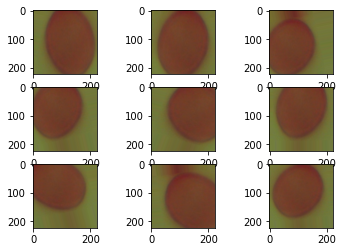

In [9]:
from matplotlib import pyplot

from numpy import expand_dims

img = np.array(data[1200])
b,g,r = cv2.split(img)           # get b, g, r
img = cv2.merge([r,g,b])

aug = ImageDataGenerator(
		rotation_range=20,
		zoom_range=0.15,
		width_shift_range=0.2,
		height_shift_range=0.2,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

img = expand_dims(img,0)

aug.fit(img)

it = aug.flow(img, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()



In [20]:

aug = ImageDataGenerator(
		rotation_range=20,
		zoom_range=0.15,
		width_shift_range=0.2,
		height_shift_range=0.2,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")


##Transfer Learned Model

Using VGG16 

Freezing top 17 layers and adding custom layers for 46 class output

In [21]:
model = applications.MobileNetV2(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))


for layer in model.layers[:17]:
    layer.trainable = False

#Adding custom Layers 

x = model.output
x = Flatten()(x)
x = Dense(4096, activation="relu")(x)
x = Dropout(0.4)(x)
x = Dense(4096, activation="relu")(x)

predictions = Dense(42, activation="softmax")(x)

# creating the final model 
model_final = Model(model.input,predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics=["accuracy"])

##Load model

In [10]:
!cp /content/gdrive/My\ Drive/USPollenKeras/VGG16weights_10.h5 ./

trained_model = model_final.load_weights('VGG16weights_10.h5')


##Train Model

Epochs - number of times we evaluate loss and accuracy

steps_per_epoch - how many batches of samples to use in each epoch

batch - number of samples shown to the network before a weight update can be performed

In [30]:
dir = "/content/gdrive/My Drive/USPollenKeras/"

n_batch = len(trainX)/2

train_generator=aug.flow(trainX, trainY, batch_size=32)
validation_data=(testX, testY)

H=model_final.fit(train_generator,batch_size = n_batch,epochs=32,verbose=1)

print("Saving weights") 
model_final.save_weights(dir+"MobileNetV2Weights_"+repr(count)+".h5")

Epoch 1/32
58/58 [==============================] - 17s 285ms/step - loss: 1.2374 - accuracy: 0.5860
Epoch 2/32
58/58 [==============================] - 16s 282ms/step - loss: 1.3009 - accuracy: 0.5575
Epoch 3/32
58/58 [==============================] - 16s 283ms/step - loss: 1.2726 - accuracy: 0.5898
Epoch 4/32
58/58 [==============================] - 17s 285ms/step - loss: 1.1735 - accuracy: 0.6123
Epoch 5/32
58/58 [==============================] - 16s 283ms/step - loss: 3.1162 - accuracy: 0.1829
Epoch 6/32
58/58 [==============================] - 17s 285ms/step - loss: 2.3110 - accuracy: 0.3045
Epoch 7/32
58/58 [==============================] - 16s 283ms/step - loss: 2.7979 - accuracy: 0.2788
Epoch 8/32
58/58 [==============================] - 16s 282ms/step - loss: 2.2177 - accuracy: 0.3133
Epoch 9/32
58/58 [==============================] - 16s 284ms/step - loss: 1.9138 - accuracy: 0.3916
Epoch 10/32
 5/58 [=>............................] - ETA: 13s - loss: 1.7224 - accuracy: 0.

KeyboardInterrupt: ignored

##Run cell below this

In [ ]:
#model_final.save_weights('VGG16weights.h5')


In [ ]:
!cp /content/img/USPollen/VGG16weights.h5 /content/gdrive/My\ Drive/USPollenKeras/


##Testing Results

In [11]:
score = model_final.evaluate(testX,testY,verbose = 0)
print("%s: %.2f%%" % (model_final.metrics_names[1], score[1]*100))


accuracy: 98.33%


In [12]:
Y_test = np.argmax(testY, axis=1)
y_pred = model_final.predict(testX)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(Y_test,y_pred,target_names=le.classes_))

                                  precision    recall  f1-score   support

           Aceracea Acer negundo       1.00      1.00      1.00        26
                    Alnus incana       1.00      1.00      1.00        26
                     Alnus rubra       1.00      1.00      1.00         7
           Ambrosia psilostachya       1.00      1.00      1.00         9
              Artemesia vulgaris       1.00      1.00      1.00        16
   Asteracea Ambrosia tridentata       0.78      1.00      0.88         7
      Asteracea Ambrosia trifida       1.00      1.00      1.00         3
Asteracea Artemesia pycnocephala       1.00      1.00      1.00         8
   Asteracea Xanthium strumarium       1.00      0.78      0.88         9
                    Betula nigra       1.00      1.00      1.00         9
             Betula occidentalis       1.00      1.00      1.00        13
                     Carya ovata       0.96      1.00      0.98        27
         Casuarina equisetifolia     

In [ ]:
N = np.arange(0, 7)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [37]:
y_pred = model_final.predict(testX)
y_pred = np.argmax(y_pred, axis=1)
Y_test = np.argmax(testY, axis=1)
for val,i in enumerate(testX):
  b,g,r = cv2.split(i)           # get b, g, r
  img = cv2.merge([r,g,b])
  plt.imshow(img)
  plt.show()
  print("Predicted: "+repr(y_pred[val])+" Actual: "+repr(Y_test[val]))





Output hidden; open in https://colab.research.google.com to view.